<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_STE_3pulses_5echoes_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pypulseq &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

In [ ]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'STE'

(STE_3pulses_5echoes_seq)=
# STE in a brain phantom

In [ ]:
# %% S1. SETUP sys
# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6
)

Calculating repetition 3 / 3 - done


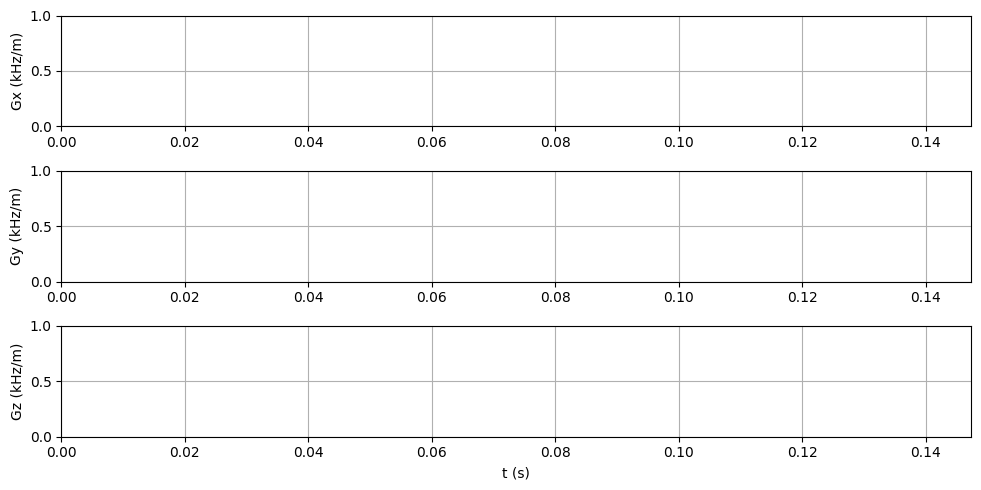

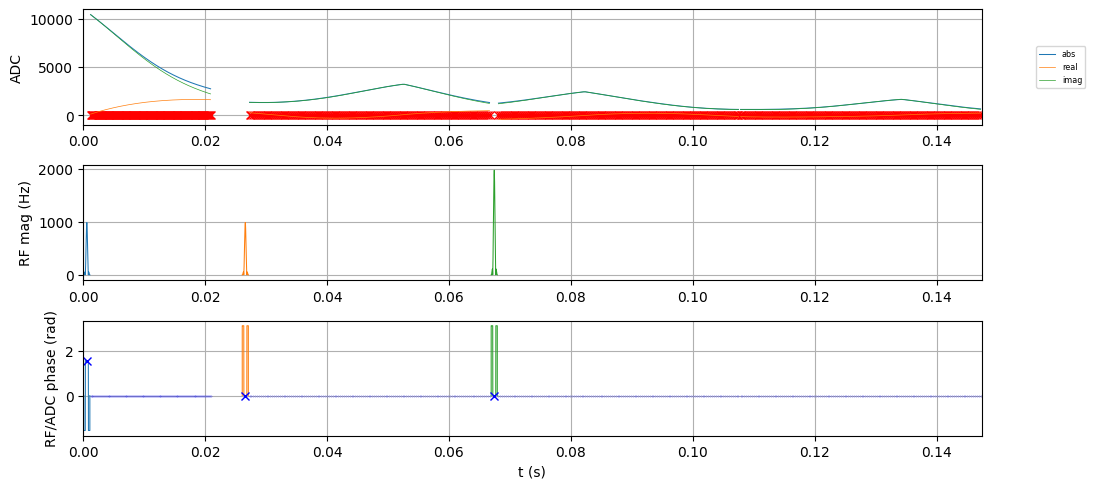

In [ ]:
#@title STE in a brain phantom - sequence
# %% S2. DEFINE the sequence, FOV and resolution
seq = pp.Sequence(system)
fov = 200e-3
Nread = 128
Nphase = 1
slice_thickness = 8e-3  # slice

# Define rf events
angle_1st2ndRF=90#@param {type:'slider', title:"1st-2nd RFs flip angle",min:0,max:90,step:10}
angle_3rdRF=180#@param {type:'slider', title:"3rd RF flip angle",min:90,max:180,step:5}

rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=angle_1st2ndRF * np.pi / 180, duration=1e-3, phase_offset=90*np.pi/180,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
rf2, _, _ = pp.make_sinc_pulse(
    flip_angle=angle_1st2ndRF * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
rf3, _, _ = pp.make_sinc_pulse(
    flip_angle=angle_3rdRF * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)

# Define other gradients and ADC events

# Define timing according to system raster times
delta_1st2ndRF=20e-3 #@param {type:'slider', title:"1st-2nd RFs delta time",min:10e-3,max:50e-3,step:5e-3}
adc_duration_OG=delta_1st2ndRF
a = int(system.adc_raster_time * Nread * 10**7)
b = int(system.grad_raster_time * 10**7)
c = int(adc_duration_OG * 10**7)
lcm_ab = abs(a * b) // np.gcd(a, b)
adc_raster_duration = (lcm_ab if round(c / lcm_ab) == 0 else round(c / lcm_ab) * lcm_ab) / 10**7

adc1 = pp.make_adc(num_samples=Nread, duration=adc_raster_duration, phase_offset=0 * np.pi / 180, system=system)
adc2 = pp.make_adc(num_samples=Nread, duration=adc_raster_duration*2, phase_offset=0 * np.pi / 180, system=system)
gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=200e-3, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)
gspoil = pp.make_trapezoid(channel='x', area=1000, duration=5e-3, system=system)


# ======
# CONSTRUCT SEQUENCE
# ======
seq.add_block(rf1)
seq.add_block(adc1)
seq.add_block(pp.make_delay(0.005))
seq.add_block(rf2)
seq.add_block(adc2)
seq.add_block(rf3)
seq.add_block(adc2)
seq.add_block(adc2)

#@title quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq,)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

In [ ]:
#@title Sequence exportation
# Prepare the sequence output for the scanner

# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', experiment_id)
seq.write(experiment_id + ".seq")

Timing check passed successfully


'e20b24a288180e0245b4e2105712f4ec'